## Visualize trained models

This notebook helps visualize the training progress as well as the resulting model

#### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import IPython
from IPython.display import display, HTML

from State_Generator import Generator
from Model import Complex_CA

#### Load model and data

In [2]:
batch_size = 8
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cpu')

model = Complex_CA(device, 8)
#model.load_state_dict(torch.load('models/complex_ca_stationary.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_best1.pth'))
model.load_state_dict(torch.load('models/complex_ca_moving_temp29.pth', map_location=torch.device('cpu')))

#model.load_state_dict(torch.load('models/complex_ca_moving_temp49.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_temp8.pth'))
#model.load_state_dict(torch.load('models/complex_ca5.pth'))

model = model.to(device)
losses = np.load('losses.npy')
#device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
generator = Generator(device, False)

#### Visualize loss during training

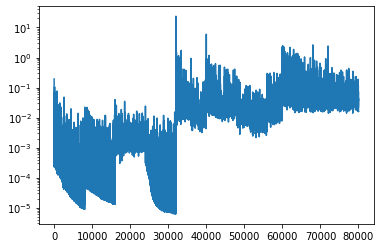

In [3]:
#fig, axes = plt.subplots()
plt.plot(losses)
plt.yscale('log')
plt.show()


#### Visualize CA - Animate

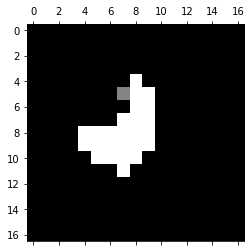

In [4]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(1, batch_size)

def extract_data(state):
    return state.x.detach().cpu().numpy()[0,0]

@torch.no_grad()
def animate(i):
    global state
    x, food, live_count = model(state.x, state.food, 1)
    state.x = x
    state.food = food
    mat.set_data(extract_data(state)) 

fig, ax = plt.subplots()
mat = ax.matshow(extract_data(state), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

#### Visualize Target data:

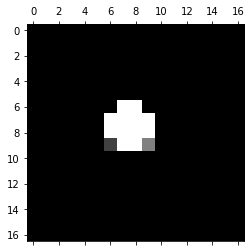

In [5]:
#use generator to test generate_moving_state
generator = Generator(device, False)
state = generator.get_centered_CA(batch_size)
#food = generator.random_food_noncentered()
food = generator.random_food(batch_size)

@torch.no_grad()
def animate(i):
    global state
    #generator.generate_moving_state(100)
    state = generator.move_towards_food(state, food)
    mat.set_data(state[0])

fig, ax = plt.subplots()
mat = ax.matshow(state[0], cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

#### Combined simulation and CA movement

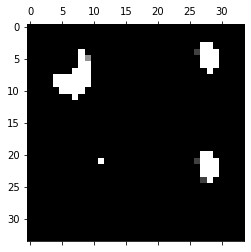

In [11]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell.detach().cpu().numpy()[0, 0], target.detach().cpu().numpy()[0]))
    row2 = np.hstack((state.food.detach().cpu().numpy()[0], state.y.detach().cpu().numpy()[0]))
    return np.vstack((row1, row2))
    return np.hstack((cell.detach().cpu().numpy()[0, 0], target.detach().cpu().numpy()[0], 
    state.food.detach().cpu().numpy()[0]))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global state
    global food_coord
    cell, food, live_count = model(cell, state.food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
    mat.set_data(extract_data(cell, target)) 

cell = state.x
target = state.x[:, 0]
food_coord = (state.food==torch.max(state.food)).nonzero()[:, 1:]
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())